In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

## 1) Dataset

In [2]:
"""#Load Dataset
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)


#Prepare X_train, y_train, X_test, y_test
composed_transform=transforms.Compose([transforms.ToTensor()])
X_train=[]
y_train=[]
for i in range(len(train_dataset)):
    X_train.append(torch.flatten(composed_transform(train_dataset[i][0]))) # for normal NN
    #X_train.append(composed_transform(train_dataset[i][0]).squeeze(0)) # for convolution
    y_train.append(train_dataset[i][0])

X_test=[]
y_test=[]
for i in range(len(test_dataset)):
    X_test.append(composed_transform(test_dataset[i][0]).squeeze(0))
    y_test.append(test_dataset[i][0])
    
print(len(y_train),len(y_test))"""

"#Load Dataset\ntrain_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)\ntest_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)\n\n\n#Prepare X_train, y_train, X_test, y_test\ncomposed_transform=transforms.Compose([transforms.ToTensor()])\nX_train=[]\ny_train=[]\nfor i in range(len(train_dataset)):\n    X_train.append(torch.flatten(composed_transform(train_dataset[i][0]))) # for normal NN\n    #X_train.append(composed_transform(train_dataset[i][0]).squeeze(0)) # for convolution\n    y_train.append(train_dataset[i][0])\n\nX_test=[]\ny_test=[]\nfor i in range(len(test_dataset)):\n    X_test.append(composed_transform(test_dataset[i][0]).squeeze(0))\n    y_test.append(test_dataset[i][0])\n    \nprint(len(y_train),len(y_test))"

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', cache=True)

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 784), (52500,), (17500, 784), (17500,))

## 2) Models

In [4]:
class BasicNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.soft = nn.Softmax()
        self.relu= nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.name="BasicNet"

        print('Network initialized')
        
    def forward(self, input, additional_out=False):
        x=input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.out(x)
        x = nn.functional.softmax(x, dim=-1)
        return x

## 3) Training

### 3.1) Initialization

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_function = nn.CrossEntropyLoss()


from skorch.callbacks import EarlyStopping

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=500,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)


from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=BasicNet,
    module__Ni= 784,
    module__Nh1 = 128,
    module__Nh2 = 128,
    module__No = 10,
    max_epochs=50,
    
    device=device,  # uncomment this to train with CUDA
    #lr=0.1,
    optimizer = optim.SGD,
    #optimizer = optim.Adam,
    optimizer__lr=0.01,
    #optimizer__weight_decay=1e-5, #L2 norm
    #criterion=nn.CrossEntropyLoss(),
    callbacks = [my_early],
    #verbose=0
)

Training device: cuda


### 3.2) Grid Search and Cross Validation

### 3.3) Normal Training

In [6]:
net.fit(X_train, y_train)

Network initialized
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2292       0.4716        2.1011  1.3133
      2        1.7473       0.6963        1.3116  1.0886
      3        1.0007       0.7867        0.7941  1.0876
      4        0.6637       0.8372        0.5881  1.1041
      5        0.5176       0.8613        0.4888  1.0891
      6        0.4439       0.8761        0.4333  1.0991
      7        0.4011       0.8853        0.3987  1.0890
      8        0.3734       0.8930        0.3752  1.1136
      9        0.3538       0.8987        0.3580  1.1203
     10        0.3388       0.9022        0.3445  1.1023
     11        0.3265       0.9056        0.3335  1.0994
     12        0.3159       0.9083        0.3239  1.0942
     13        0.3065       0.9107        0.3154  1.0996
     14        0.2979       0.9138        0.3077  1.0860
     15        0.2901       0.9159        0.3005  1.1008
     16    

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BasicNet(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=10, bias=True)
    (soft): Softmax(dim=None)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  ),
)

### 3.4) Plot Losses

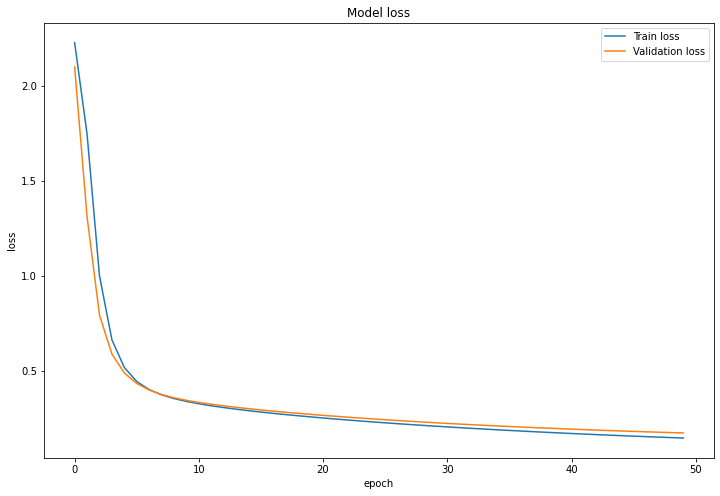

In [7]:
import datetime
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
#plt.savefig("models/"+save_name+"_Losses", dpi=400)
plt.show()

## 4) Test the model

In [25]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(test_acc)

## 5) Metrics Summary

In [19]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
						  save_path='models/'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig(save_path+"_picConfMatrix.png", dpi=400)
    plt.tight_layout()

Val Acc:	 0.951
Test Acc:	 0.95
Precision:	 0.95
Recall:		 0.95
F1:		 0.95


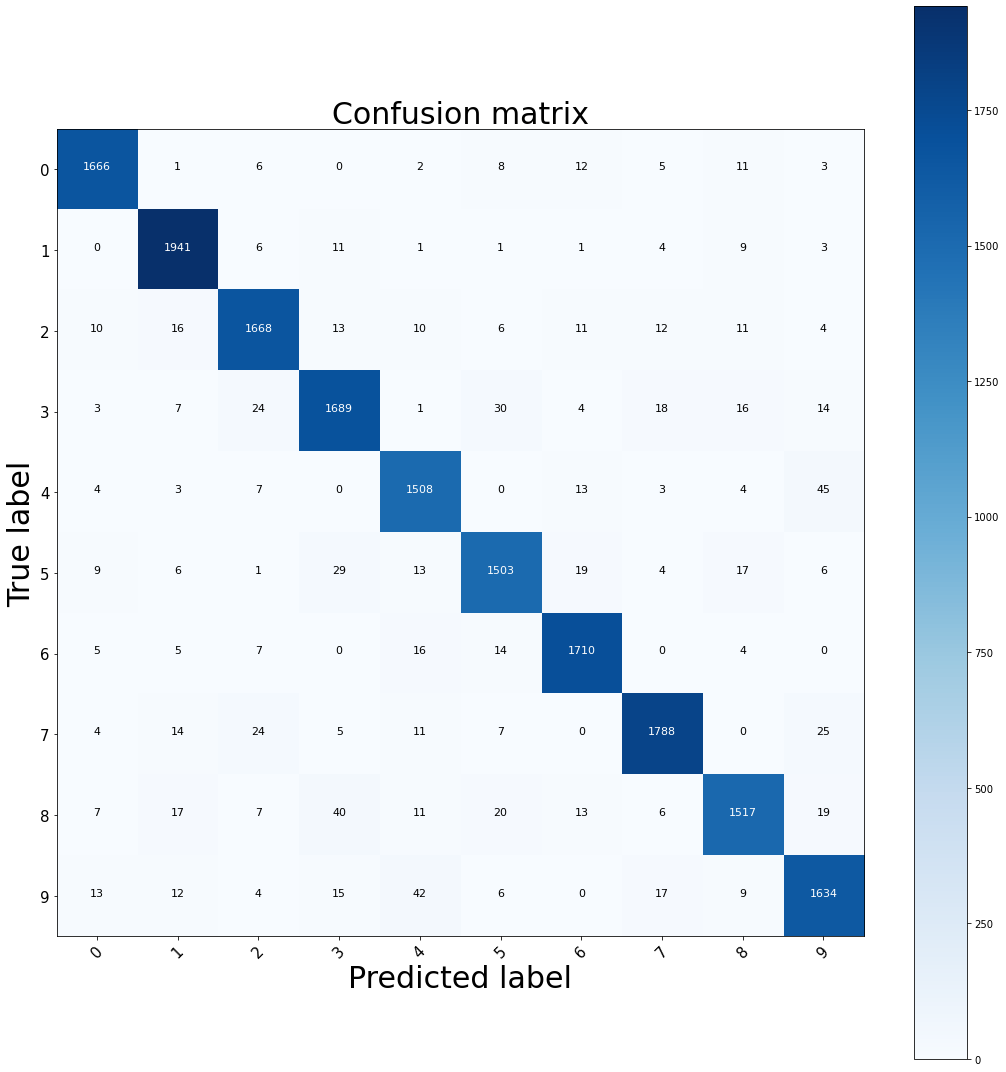

In [22]:
#Accuracy
val_acc=history[:, 'valid_acc'][-1]
print("Val Acc:\t",round(val_acc,3))
print("Test Acc:\t",round(float(test_acc),3))

# Precision and Recall(sensitivity/true positive rate)
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_test, y_pred,average='micro')
rec=recall_score(y_test, y_pred,average='micro')

#F1 - high if both recall and precision are high.
from sklearn.metrics import f1_score
f1=f1_score(y_test, y_pred,average='micro')

print("Precision:\t",round(prec,3))
print("Recall:\t\t",round(rec,3))
print("F1:\t\t",round(f1,3))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
categories=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cm,categories, normalize=False,save_path="models/"+save_name)


## 6) Save the model

In [ ]:
#Saving the whole model
import pickle
with open("models/"+save_name+".pkl", 'wb') as f:
    pickle.dump(net, f)
    
#Load the model
#with open(file_name, 'rb') as f:
#    new_net = pickle.load(f)

#Save Metrics to File
f = open("models/"+save_name+"_Metrics.txt", "a")
f.write('Train loss:\t'+ str(round(train_loss,3))+ "\n")
f.write('Val loss:\t'+ str(round(val_loss,3))+ "\n")
f.write('Val acc:\t'+ str(round(val_acc,3))+ "\n")
f.write('Test acc:\t'+ str(round(test_acc,3))+ "\n")
f.write("Precision:\t"+str(round(prec,3))+ "\n")
f.write("Recall:\t\t"+str(round(rec,3))+ "\n")
f.write("F1:\t\t"+str(round(f1,3)))

f.close()

In [26]:
#Most mispredicted labels
n_mistakes=10
import heapq
h=[]
nCategories=10
for i in range(nCategories):
    for j in range(i+1,nCategories):
        heapq.heappush(h,(cm[i,j]+cm[j,i],(i,j)))
for e in heapq.nlargest(n_mistakes,h):
    print(e[0],e[1][0],"-",e[1][1])

f = open("models/"+save_name+"_Metrics.txt", "a")
f.write('\n\nMost '+str(n_mistakes)+ ' mispredicted labels\n')
for e in heapq.nlargest(n_mistakes,h):
    f.write(str(e[0])+"\t"+str(categories[e[1][0]])+"-"+str(categories[e[1][1]])+"\n")
f.close()

87 4 - 9
59 3 - 5
56 3 - 8
42 7 - 9
37 5 - 8
37 2 - 3
36 2 - 7
33 5 - 6
29 4 - 6
29 3 - 9


## 7) Network Analysis

### 7.1) Weights histogram

In [27]:
#Access network parameters
my_best_net = net.module_

#First hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = my_best_net.fc2.weight.data.cpu().numpy()
h2_b = my_best_net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = my_best_net.out.weight.data.cpu().numpy()
out_b = my_best_net.out.bias.data.cpu().numpy()

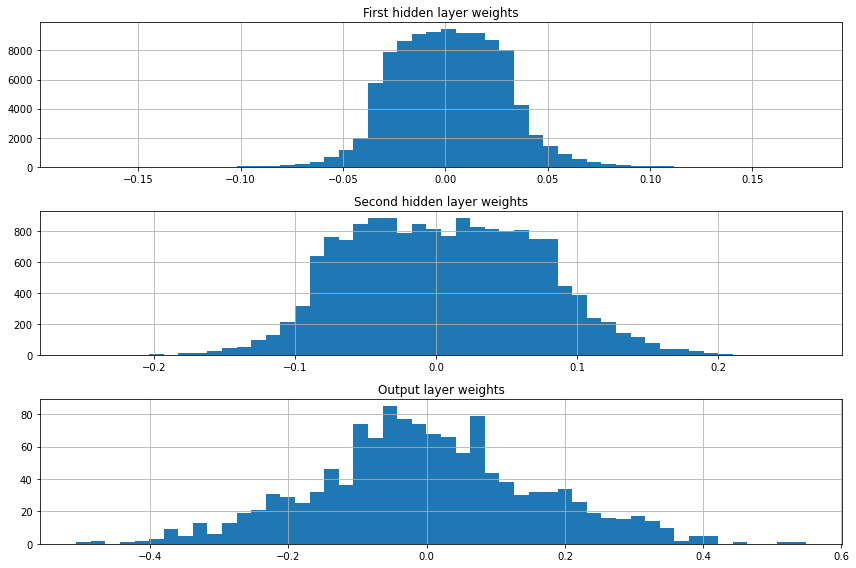

In [28]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig("models/"+save_name+"_Weights-histogram", dpi=400)
plt.show()

### 7.2) Analyze activations

In [36]:
def get_activation(layer, input, output):
    global activation
    activation = torch.softmax(output)
    
### Register hook
net=my_best_net
hook_handle = net.fc2.register_forward_hook(get_activation)


### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor(X_test[0]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor(X_test[1]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor(X_test[2]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.savefig("models/"+save_name+"_Activations", dpi=400)
plt.show()

TypeError: expected np.ndarray (got Tensor)

### 7.3) Receptive fields

In [ ]:

"""
linear combination method for visualising the features discussed in class, which is straightforward for the fully-connected model. Then if you wish you can explore more sophisticated methods, such as the method that allows to create an "optimal" image that maximally activates the neuron. This can be "easily" done also for the CNN. In any case, receptive fields are meaningful only for the classification task.

"""


Label: 0


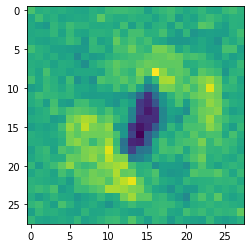


Label: 1


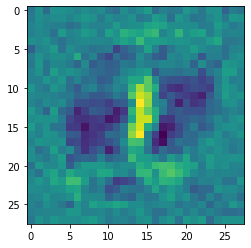


Label: 2


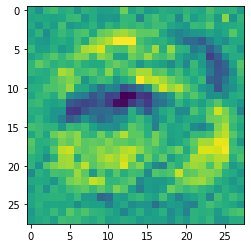


Label: 3


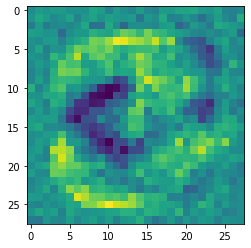


Label: 4


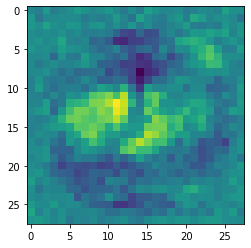


Label: 5


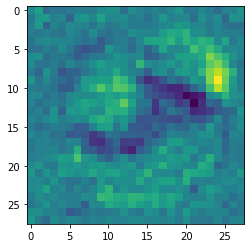


Label: 6


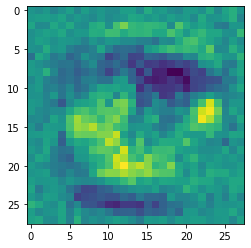


Label: 7


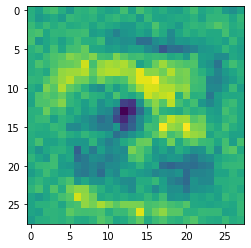


Label: 8


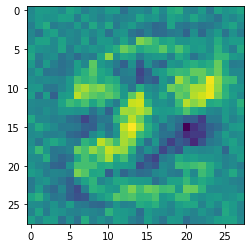


Label: 9


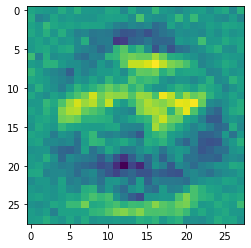

In [32]:
#FULLY CONNECTED NED
#Receptive fields of the last layer
for ii in range(10):
    vis3 = np.matmul(out_w[ii],np.matmul(h2_w,h1_w))
    print("\nLabel:", ii)
    plt.imshow(vis3.reshape(784).reshape(28,28))
    plt.show()